In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
os.chdir("src")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from anomaly_detection import *
from utils import *
from data_preparation import *
from constants import DATA_PATH, SEP_CSV

from hyperparameter import *

# os.chdir("../")

In [5]:
def detect_anomalies(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4, lookback=20, threshold=0.2):
    # Get the data
    df_prep = get_data()

    # Check dataset formatting
    required_columns = ['c_FEATURE_1', 'c_FEATURE_2', 'c_FEATURE_3', 'c_FEATURE_4']
    missing_columns = set(required_columns) - set(df_prep.columns)
    if missing_columns:
        raise ValueError(f"Missing required columns in the dataset: {missing_columns}")

    timeseries = get_filtered_timeseries(df_prep, c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(timeseries.values)

    # Prepare the data for LSTM
    def prepare_data(timeseries, lookback):
        X, y = [], []
        for i in range(len(timeseries) - lookback):
            X.append(timeseries[i:i + lookback])
            y.append(timeseries[i + lookback])
        return np.array(X), np.array(y)

    X, y = prepare_data(normalized_data, lookback)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Perform hyperparameter tuning
    best_hyperparameters, _ = hyperparameter_tuning(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4, lookback)

    # Update the hyperparameters
    epochs = best_hyperparameters['epochs']
    batch_size = best_hyperparameters['batch_size']

    # Build and train the LSTM model using the updated hyperparameters
    model = Sequential()
    model.add(LSTM(64, input_shape=(lookback, 1)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'], run_eagerly=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # Predict the anomalies using the trained LSTM model
    predicted_data = model.predict(X)
    anomalies = predicted_data - y > threshold

    # Optionally, you can plot the detected anomalies and return the anomalies and dates:
    def plot_anomalies(data, anomalies):
        plt.plot(data, label='Data')

        anomaly_indices = np.where(anomalies)[0] + lookback
        anomaly_dates = timeseries.index[anomaly_indices]

        anomalies_dict = {index: date for index, date in zip(anomaly_indices, anomaly_dates)}
        dates_dict = {index: date for index, date in enumerate(timeseries.index)}

        if len(anomaly_indices) > 0:
            plt.scatter(anomaly_indices, data[anomaly_indices], color='r', label='Anomaly')

        predicted_indices = np.arange(lookback, len(data))
        plt.plot(predicted_indices, predicted_data, color='g', label='Predicted')

        plt.legend()
        plt.show()

        # Sort the anomalies_dict by timestamp
        sorted_anomalies_dict = {index: anomalies_dict[index] for index in sorted(anomalies_dict, key=lambda x: anomalies_dict[x])}

        return sorted_anomalies_dict, dates_dict

    # Call the plot_anomalies function and store the returned dictionaries
    anomalies_dict, dates_dict = plot_anomalies(normalized_data, anomalies)

    # Print anomalies and their dates
    print("Anomalies:", len(anomalies_dict))
    print("Dates:", len(dates_dict))

    # Define the generalizable nomenclature for anomalies
    nomenclature = {
        'Magnitude': {
            'High': 'Anomaly with high magnitude',
            'Low': 'Anomaly with low magnitude'
        },
        'Trend': {
            'Increasing': 'Anomaly with increasing trend',
            'Decreasing': 'Anomaly with decreasing trend',
            'Abrupt Change': 'Anomaly with abrupt change in trend'
        },
        'Seasonality': {
            'Seasonal Peak': 'Anomaly with seasonal peak',
            'Seasonal Dip': 'Anomaly with seasonal dip'
        },
        'Spikes and Drops': {
            'Spike': 'Spike anomaly',
            'Drop': 'Drop anomaly'
        },
        'Persistent': {
            'Persistent High': 'Anomaly with persistent high value',
            'Persistent Low': 'Anomaly with persistent low value'
        }
    }

    # Categorize and label the anomalies based on the nomenclature
    categorized_anomalies = {}
    for index, date in anomalies_dict.items():
        anomaly_label = []

        # Determine magnitude
        if normalized_data[index] > 0.8:
            anomaly_label.append('High Magnitude')
        elif normalized_data[index] < 0.2:
            anomaly_label.append('Low Magnitude')

        # Determine trend
        if normalized_data[index] > normalized_data[index - 1]:
            anomaly_label.append('Increasing Trend')
        elif normalized_data[index] < normalized_data[index - 1]:
            anomaly_label.append('Decreasing Trend')
        else:
            anomaly_label.append('Abrupt Change')

        # Determine seasonality
        month = date.month
        if month in [3, 6, 12]:
            anomaly_label.append('Seasonal Peak')
        elif month in [1, 2, 8]:
            anomaly_label.append('Seasonal Dip')

        # Determine spikes and drops
        if normalized_data[index] - normalized_data[index - 1] > 0.2:
            anomaly_label.append('Spike')
        elif normalized_data[index] - normalized_data[index - 1] < -0.2:
            anomaly_label.append('Drop')

        # Determine persistence
        is_persistent_high = np.all(normalized_data[index:index + 5] > 0.8)
        is_persistent_low = np.all(normalized_data[index:index + 5] < 0.2)
        if is_persistent_high:
            anomaly_label.append('Persistent High')
        elif is_persistent_low:
            anomaly_label.append('Persistent Low')

        # Create the final label for the anomaly
        anomaly_label = ' + '.join(anomaly_label)
        categorized_anomalies[index] = anomaly_label

    print("Categorized Anomalies:")
    for index, label in categorized_anomalies.items():
        print(f"Anomaly at index {index} on date {anomalies_dict[index]}: {label}")

    # return anomalies_dict, categorized_anomalies/

In [6]:
best_hyperparameters, best_f1_score = hyperparameter_tuning('Niederlande', 'PGO', 'Roadster', 'unspec.', lookback=10)

Epoch 1/10
1/1 [==============================] - 0s 93ms/step - loss: 0.1041 - accuracy: 0.3636
Epoch 2/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0971 - accuracy: 0.3636
Epoch 3/10
1/1 [==============================] - 0s 30ms/step - loss: 0.0909 - accuracy: 0.3636
Epoch 4/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0855 - accuracy: 0.3636
Epoch 5/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0808 - accuracy: 0.3636
Epoch 6/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0771 - accuracy: 0.3636
Epoch 7/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0743 - accuracy: 0.3636
Epoch 8/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0725 - accuracy: 0.3636
Epoch 9/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0718 - accuracy: 0.3636
Epoch 10/10
1/1 [==============================] - 0s 30ms/step


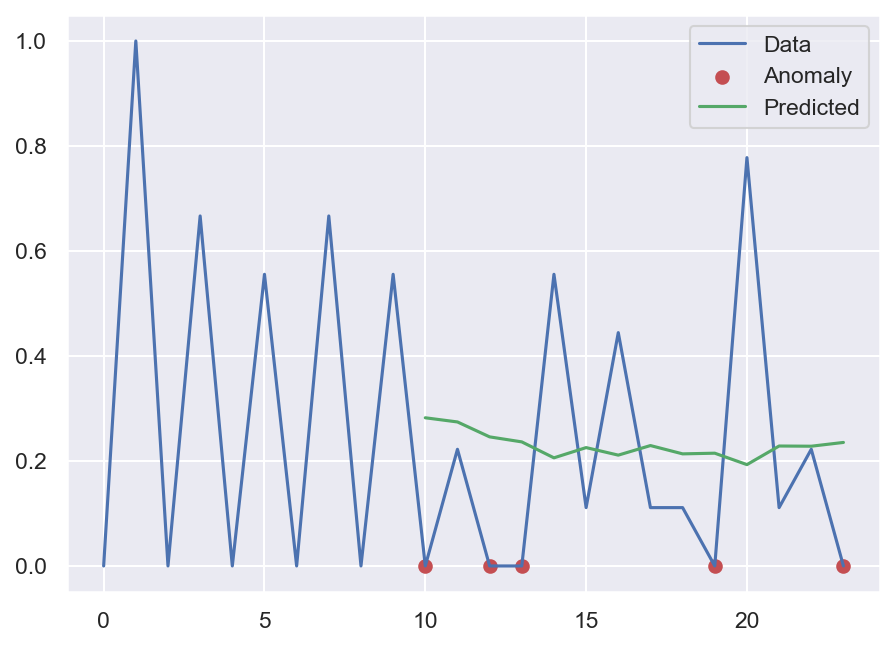

Anomalies: 5
Dates: 24
Categorized Anomalies:
Anomaly at index 10 on date 2004-06-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Drop
Anomaly at index 12 on date 2004-07-01 00:00:00: Low Magnitude + Decreasing Trend + Drop
Anomaly at index 13 on date 2005-07-01 00:00:00: Low Magnitude + Abrupt Change
Anomaly at index 19 on date 2005-10-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 23 on date 2005-12-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Drop + Persistent Low


In [7]:
detect_anomalies('Niederlande', 'PGO', 'Roadster', 'unspec.', lookback=best_hyperparameters['lookback'], threshold=best_hyperparameters['threshold'])

In [8]:
best_hyperparameters, best_f1_score = hyperparameter_tuning('Belgien', 'Alfa Romeo', 'Coupe', '4C', lookback=10)

Epoch 1/20
2/2 [==============================] - 0s 31ms/step - loss: 0.0770 - accuracy: 0.3051
Epoch 2/20
2/2 [==============================] - 0s 56ms/step - loss: 0.0658 - accuracy: 0.3051
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.0578 - accuracy: 0.3051
Epoch 4/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0542 - accuracy: 0.3051
Epoch 5/20
2/2 [==============================] - 0s 31ms/step - loss: 0.0545 - accuracy: 0.3051
Epoch 6/20
2/2 [==============================] - 0s 29ms/step - loss: 0.0558 - accuracy: 0.3051
Epoch 7/20
2/2 [==============================] - 0s 29ms/step - loss: 0.0565 - accuracy: 0.3051
Epoch 8/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0554 - accuracy: 0.3051
Epoch 9/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0542 - accuracy: 0.3051
Epoch 10/20
2/2 [==============================] - 0s 42ms/step - loss: 0.0532 - accuracy: 0.3051
Epoch 11/20
2/2 [============

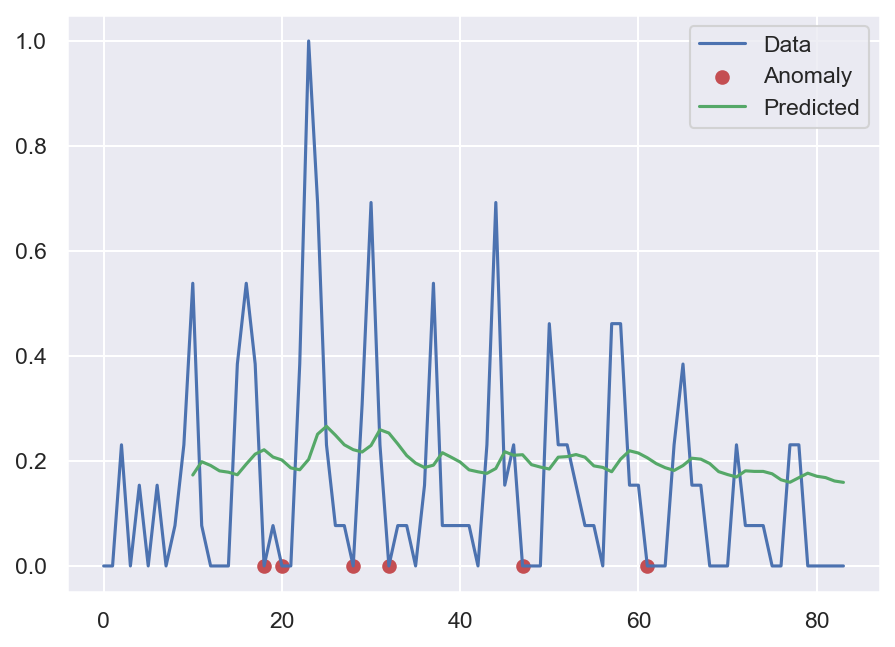

Anomalies: 6
Dates: 84
Categorized Anomalies:
Anomaly at index 28 on date 2013-05-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 18 on date 2017-03-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Drop
Anomaly at index 32 on date 2017-05-01 00:00:00: Low Magnitude + Decreasing Trend + Drop + Persistent Low
Anomaly at index 47 on date 2018-07-01 00:00:00: Low Magnitude + Decreasing Trend + Drop
Anomaly at index 61 on date 2018-09-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 20 on date 2019-03-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak


In [9]:
detect_anomalies('Belgien', 'Alfa Romeo', 'Coupe', '4C', lookback=best_hyperparameters['lookback'], threshold=best_hyperparameters['threshold'])

In [10]:
best_hyperparameters, best_f1_score = hyperparameter_tuning('Belgien', 'MINI', 'Cabrio', '', lookback=10)

Epoch 1/10
5/5 [==============================] - 0s 32ms/step - loss: 0.1262 - accuracy: 0.0786
Epoch 2/10
5/5 [==============================] - 0s 31ms/step - loss: 0.0785 - accuracy: 0.0786
Epoch 3/10
5/5 [==============================] - 0s 34ms/step - loss: 0.0692 - accuracy: 0.0750
Epoch 4/10
5/5 [==============================] - 0s 35ms/step - loss: 0.0697 - accuracy: 0.0679
Epoch 5/10
5/5 [==============================] - 0s 32ms/step - loss: 0.0650 - accuracy: 0.0750
Epoch 6/10
5/5 [==============================] - 0s 32ms/step - loss: 0.0619 - accuracy: 0.0786
Epoch 7/10
5/5 [==============================] - 0s 32ms/step - loss: 0.0607 - accuracy: 0.0786
Epoch 8/10
5/5 [==============================] - 0s 36ms/step - loss: 0.0592 - accuracy: 0.0786
Epoch 9/10
5/5 [==============================] - 0s 31ms/step - loss: 0.0581 - accuracy: 0.0786
Epoch 10/10
11/11 [==============================] - 0s 11ms/step


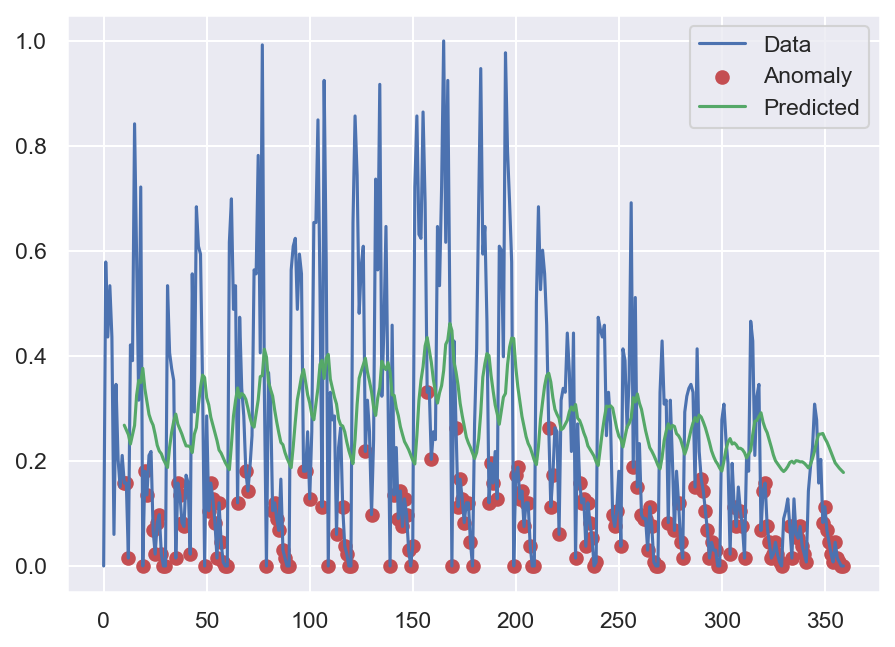

Anomalies: 173
Dates: 360
Categorized Anomalies:
Anomaly at index 30 on date 2004-02-01 00:00:00: Low Magnitude + Abrupt Change + Seasonal Dip
Anomaly at index 60 on date 2004-03-01 00:00:00: Low Magnitude + Abrupt Change + Seasonal Peak
Anomaly at index 90 on date 2004-04-01 00:00:00: Low Magnitude + Abrupt Change
Anomaly at index 120 on date 2004-05-01 00:00:00: Low Magnitude + Abrupt Change
Anomaly at index 150 on date 2004-06-01 00:00:00: Low Magnitude + Increasing Trend + Seasonal Peak
Anomaly at index 333 on date 2007-12-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Persistent Low
Anomaly at index 29 on date 2008-01-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Dip
Anomaly at index 59 on date 2008-02-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Dip
Anomaly at index 89 on date 2008-03-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak
Anomaly at index 119 on date 2008-04-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at in

In [11]:
detect_anomalies('Belgien', 'MINI', 'Cabrio', '', lookback=10, threshold=best_hyperparameters['threshold'])